<a href="https://colab.research.google.com/github/yvonny/churn/blob/master/ChurnPredictionBaseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Paper: https://www.andrew.cmu.edu/user/lakoglu/pubs/StackOverflow-churn.pdf

Description of datasets: https://ia800107.us.archive.org/27/items/stackexchange/readme.txt

Site for download of datasets: https://archive.org/details/stackexchange

This code has 6 steps

1. Load StackOverflow datasets as dataframe
2. Extract and label the datasets for each task
3. Extract features for each task
4. Analyze features
5. Train models for each task with the features
6. Quantify the importance of each feature category

1. Load StackOverflow datasets as dataframe

In [3]:
import sys
!{sys.executable} -m pip install xmltodict

In [0]:
import xmltodict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
gdrive = GoogleDrive(gauth)

In [0]:
def store_df_at_google_drive(fname, df, ftype=None):
    s = io.StringIO()
    if ftype == 'png':
      uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
      uploaded.SetContentFile('%s.png'%(fname))
      uploaded.Upload()
      print('Uploaded file with ID {}'.format(uploaded.get('id')))
    else:
      df.to_csv(s)
      uploaded = gdrive.CreateFile({'title': fname, 'parents':[{'id': 'root'}]})
      uploaded.SetContentString(s.getvalue())
      uploaded.Upload()
    print('Uploaded file with ID {}'.format(uploaded.get('id')))

def load_df_at_google_drive(fname):
    file_list = gdrive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
    for file1 in file_list:
        if (file1['title'] == fname):
            downloaded = gdrive.CreateFile({'id': file1['id']})
            s = io.StringIO(downloaded.GetContentString())
            return pd.read_csv(s)
    
def load_dataset_from_google_drive(dir_id):
    files = []
    file_list = gdrive.ListFile({'q': "'{}' in parents".format(dir_id)}).GetList()
    for f in file_list:
      if f['title'] in ['Users.xml', 'Posts.xml','users_reduce.pkl', 'posts_reduce.pkl']:
          print('  Load file: {}'.format(f['title']))
          f_ = gdrive.CreateFile({'id': f['id']})
          f_.GetContentFile(f['title'])
          files.append(f['title'])
    return files

In [9]:
files = load_dataset_from_google_drive('1Fp_7GDH_t7xfnU8aXeKrcBC54_nECOcu') 

  Load file: users_reduce.pkl
  Load file: posts_reduce.pkl


In [12]:
users_df = pd.read_pickle("{}.pkl".format('users_reduce'))   # shape: (992,110, 3)
posts_df = pd.read_pickle("{}.pkl".format('posts_reduce'))   # shape: (11,324,326, 10)

users_df.shape, posts_df.shape   # Total dataset

((992110, 3), (11324326, 10))

2. Extract and label the datasets for each tasks

You should extract the dataset for the period of the dataset: July 31, 2008 ~ July 31, 2012

There are 2 tasks:

A. After a user's K-th post, predict how likely it is that the user will churn

B. After the T-th day from the account creation of a user, predict how likely it is that the user will churn

In [19]:
def getIthOfPosts(posts):
    print('getIthOfPosts')
    posts.sort_values(by=['OwnerUserId', 'CreationDate'], inplace=True)
    posts.reset_index(level=0, inplace=True)
    posts['id_owner_time'] = posts.index
    first_posts = posts.groupby('OwnerUserId')['id_owner_time'].min().to_frame()
    tmp = posts.join(first_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    posts['ith'] = tmp['id_owner_timeF'] - tmp['id_owner_timeP'] + 1
    posts = posts.drop(['id_owner_time'], axis=1)
    return posts

# You should extract the dataset for the period of the dataset: July 31, 2008 ~  July 31, 2012
start_time = pd.to_datetime('2008-07-31')
end_time = pd.to_datetime('2012-07-31')
end_time_2 = pd.to_datetime('2012-01-31')

posts_df = posts_df[(posts_df['CreationDate'] >= start_time) & (posts_df['CreationDate'] <= end_time)]
users_df = users_df[(users_df['CreationDate'] >= start_time) & (users_df['CreationDate'] <= end_time_2)]


posts_df = getIthOfPosts(posts_df)

getIthOfPosts


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/inde

In [35]:
posts_df.head(5)

,Id,PostTypeId,AcceptedAnswerId,CreationDate,Score,OwnerUserId,AnswerCount,CommentCount,ParentId,CreationDateOfOwner,BodyWordNum,ith,DataframeIndex
0,3609905,3,NaN,2010-07-22 18:39:58.787,0.0,-1,0.0,0.0,NaN,2008-07-31,48.0,1,0
1,3625049,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,8.0,2,1
2,3625050,3,NaN,2010-08-01 09:51:37.270,0.0,-1,0.0,0.0,NaN,2008-07-31,7.0,3,2
3,3621159,3,NaN,2010-08-02 06:04:30.050,0.0,-1,0.0,0.0,NaN,2008-07-31,0.0,4,3
4,3625171,3,NaN,2010-08-02 18:22:47.767,0.0,-1,0.0,0.0,NaN,2008-07-31,176.0,5,4


In [36]:
users_df.head(5)

,Reputation,CreationDate,LastAccessDate,num_posts
Id,,,,
-1,1,2008-07-31 00:00:00.000,2008-08-26 00:16:53.810,3126.0
1,47044,2008-07-31 14:22:31.287,2019-08-16 05:05:51.480,142.0
2,3677,2008-07-31 14:22:31.287,2019-08-29 19:51:51.283,11.0
3,13706,2008-07-31 14:22:31.287,2019-08-30 19:52:29.747,38.0
4,29608,2008-07-31 14:22:31.317,2019-08-11 05:08:53.910,176.0


In [0]:
# Dataset in Task 1
#   Posts: Extract K posts of each user
#   Users: Extract users who post at least K


def getTask1Posts(posts, K):
    tmp = posts[posts['ith'] == K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    tmp = posts[posts['OwnerUserId'].isin(tmp.index)]
    return tmp[tmp['ith'] <= K]


def getTask1Users(users, posts, K):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= K]
    return users


In [0]:
list_of_K = range(1, 21)
users_of_task1, posts_of_task1 = {}, {}


for K in list_of_K:
    posts_of_task1[K] = getTask1Posts(posts_df, K)
    users_of_task1[K] = getTask1Users(users_df, posts_df, K)

In [43]:
# Churn in Task 1
#   Churners: Users who did not post for at least 6 months from their K-th post 
#   Stayers:  Users who created at least one post within the 6 months from their K-th post

def prepareFeaturesTask1(users, posts, K):
    tmp = posts[posts['ith']==K]['OwnerUserId'].to_frame()
    tmp = tmp.set_index('OwnerUserId')
    posts = posts[posts['OwnerUserId'].isin(tmp.index)]

    posts_task = posts[posts['OwnerUserId'].isin(users.index)]
    posts_Kth_time = posts_task[posts_task['ith']==K]
    posts_Kth_time = posts_Kth_time.set_index('OwnerUserId')['CreationDate']
    posts_deadline = posts_Kth_time + pd.tseries.offsets.DateOffset(months=6)
    
    posts_stayer = posts_task[posts_task['ith'] > K].groupby('OwnerUserId')['CreationDate'].min().to_frame()
    posts_stayer = posts_stayer.merge(posts_deadline, on='OwnerUserId', how='left', suffixes=('_left', '_right'))
    
    posts_churner1 = posts_stayer[posts_stayer['CreationDate_left'] > posts_stayer['CreationDate_right']]
    posts_churner1['is_churn'] = 1
    posts_churner1 = posts_churner1[['is_churn']]
    posts_stayer = posts_stayer[posts_stayer['CreationDate_left'] <= posts_stayer['CreationDate_right']]
    posts_stayer['is_churn'] = 0    
    posts_stayer = posts_stayer[['is_churn']]
       
    posts_churner2 = posts_task[posts_task['ith'] >= K].groupby('OwnerUserId').count()
    posts_churner2 = posts_churner2[posts_churner2['CreationDate'] == 1][['CreationDate']]
    posts_churner2['is_churn'] = 1
    posts_churner2 = posts_churner2[['is_churn']]
    
    posts = pd.concat([posts_stayer, posts_churner1, posts_churner2])
    posts = posts.rename(columns={'OwnerUserId': 'Id'})
    users['is_churn'] = 0
    users.update(posts)
    return users

features_of_task1 = {}

for K in list_of_K:
    features_of_task1[K] = prepareFeaturesTask1(users_of_task1[K], posts_df, K)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [0]:
# Dataset in Task 2
#   Users: Extract users who post at least 1
#   Posts: Extract posts which create before T day from the account creation of the owner

def getCreationDateOfOwner(users, posts):
    posts['DataframeIndex'] = posts.index
    posts['CreationDateOfOwner'] = posts.set_index('OwnerUserId')\
            .join(users, how='inner', rsuffix='OfOwner')\
            .set_index('DataframeIndex')['CreationDateOfOwner']
    posts = posts.drop(['DataframeIndex'], axis=1)
    return posts['CreationDateOfOwner']

  
def getTask2Posts(users, posts, T):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    observation_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    posts = posts[posts['CreationDate'] <= observation_deadline]
    return posts
  
def getTask2Users(users, posts):
    users['num_posts'] = posts.groupby('OwnerUserId')['OwnerUserId'].count()
    users = users[users['num_posts'] >= 1]
    return users
  
list_of_T = [7, 15, 30]
users_of_task2 = {}
posts_of_task2 = {}

for T in list_of_T:
    posts_of_task2[T] = getTask2Posts(users_df, posts_df, T)
    users_of_task2[T] = getTask2Users(users_df, posts_df)

In [30]:
# Churn in Task2
#   Churners: Users who did not post for at least 6 months from T days after account creation
#   Stayers:  Users who created at least one post within the 6 months from T days after account creation

def prepareFeaturesTask2(users, posts, T=30):
    if 'CreationDateOfUser' not in posts.columns:
        posts['CreationDateOfOwner'] = getCreationDateOfOwner(users, posts)
    users = getTask1Users(users, posts, K=1)
    observe_deadline = posts['CreationDateOfOwner'] + pd.offsets.Day(T)
    churn_deadline = observe_deadline + pd.tseries.offsets.DateOffset(months=6)
    posts_observed = posts[(posts['CreationDate'] <= observe_deadline) & (posts['CreationDate'] >= posts['CreationDateOfOwner'])]
    posts_after_observe = posts[(posts['CreationDate'] <= churn_deadline) & (posts['CreationDate'] > observe_deadline)]
    label_df = users.reindex((posts_observed.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index)
    stayers = (posts_after_observe.groupby('OwnerUserId')['OwnerUserId'].count() > 0).index
    churners = list(set(label_df.index) - set(stayers))
    label_df['is_churn'] = 0.
    label_df.loc[churners, 'is_churn'] = 1.
    return label_df

features_of_task2 = {}
for T in list_of_T:
    features_of_task2[T] = prepareFeaturesTask2(users_of_task2[T], posts_df, T)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


7              Reputation            CreationDate  ... num_posts  is_churn
OwnerUserId                                      ...                    
1                 47044 2008-07-31 14:22:31.287  ...       142       0.0
2                  3677 2008-07-31 14:22:31.287  ...        11       0.0
3                 13706 2008-07-31 14:22:31.287  ...        38       0.0
5                 40819 2008-07-31 14:22:31.317  ...       322       0.0
8                   942 2008-07-31 21:33:24.057  ...         1       1.0
9                 15643 2008-07-31 21:35:26.517  ...        55       0.0
11                 2023 2008-08-01 00:59:11.147  ...         1       1.0
13               187952 2008-08-01 04:18:04.943  ...      1227       0.0
17                46586 2008-08-01 12:02:21.617  ...       574       0.0
19                 1536 2008-08-01 12:05:14.233  ...        14       1.0
20                 9176 2008-08-01 12:09:11.010  ...       102       0.0
22                14204 2008-08-01 12:11:11.897  

3. Extract features for each task

3-1. Temporal features

In [0]:
# Temporal features 1: gap1
def getTimeGap1OfUser(users, posts):
    creation_date_user = users['CreationDate']
    creation_date_first_post = posts.groupby('OwnerUserId')['CreationDate'].min()
    return (creation_date_first_post - creation_date_user).dt.total_seconds()

In [0]:
# Temporal features 2: gapK  (units: min)
# k > 2
def getTimeGapkOfPosts(posts, k):
    date_1 = posts[posts['ith'] == (k-1)].sort_values('OwnerUserId')
    date_2 = posts[posts['ith'] == k].sort_values('OwnerUserId')
    date_2 = date_2.set_index('OwnerUserId')
    date_1 = date_1.set_index('OwnerUserId')
    result = (date_2['CreationDate'] - date_1['CreationDate']).dt.total_seconds() / 60  
    return result

In [0]:
# Temporal features 3: last_gap (units : min)
def getTimeLastGapOfPosts(posts):
    last_posts = posts.groupby('OwnerUserId')['CreationDate'].max().to_frame()
    tmp = posts.join(last_posts, on='OwnerUserId', how='inner', lsuffix='F', rsuffix='P')
    tmp = tmp[tmp['CreationDateF'] < tmp['CreationDateP']].groupby('OwnerUserId')['CreationDateF'].max().to_frame()
    return (last_posts['CreationDate'] - tmp['CreationDateF']).dt.total_seconds() / 60

In [0]:
# Temporal features 4: time_since_last_post (units: min)
def getTimeSinceLastPost(users, posts, T):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    creation_after_T_days_date = users['CreationDate'] + pd.offsets.Day(T)
    return (creation_after_T_days_date - last_post_date).dt.total_seconds() / 60


In [0]:
# Temporal features 5: mean_gap
def getTimeMeanGap(posts):
    last_post_date = posts.groupby('OwnerUserId')['CreationDate'].max()
    first_post_date = posts.groupby('OwnerUserId')['CreationDate'].min()
    num_posts = posts.groupby('OwnerUserId')['CreationDate'].count()
    return (last_post_date - first_post_date).dt.total_seconds() / 60 / num_posts


In [44]:
# Extract temporal features for task1
for K in list_of_K:
    features_of_task1[K]['gap1'] = getTimeGap1OfUser(users_of_task1[K], posts_of_task1[K])
    for k in range(2, K+1):
        features_of_task1[K]['gap{}'.format(k)] = getTimeGapkOfPosts(posts_of_task1[K], k)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs

K=1


FileNotFoundError: ignored

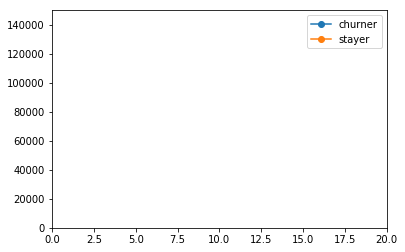

In [50]:
# Figure 2: Gap between posts
#    For a user who churns, gap between consecutive posts keeps increasing. 
#    Gaps for those who stay are much lower, and stabilize around 20,000 minutes,
#    indicating routine posting activity in every ≈2 weeks.
clist = []
slist = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners_gap = []
    stayers_gap = []
    for i in range(2, K+1):
        gapK = 'gap{}'.format(i)
        sum_gapK = list(subgroup.groupby('is_churn')[gapK].sum())
        count_gapK = list(subgroup.groupby('is_churn')[gapK].count())
        if len(sum_gapK) < 2:
            break
        churners_gap.append(sum_gapK[1] / count_gapK[1])
        stayers_gap.append(sum_gapK[0] / count_gapK[0])

    clist.append(churners_gap)
    slist.append(stayers_gap)
    
    print("K={}".format(K))
    plt.plot(churners_gap, '-o', label='churner')
    plt.plot(stayers_gap, '-o', label='stayer')
    plt.legend()
    plt.axis((0,20,0,15e4))
    store_df_at_google_drive('task1_{0}posts_{1}'.format(K,'TimeGap1OfUser'),pd.DataFrame(),'png')
    plt.show()

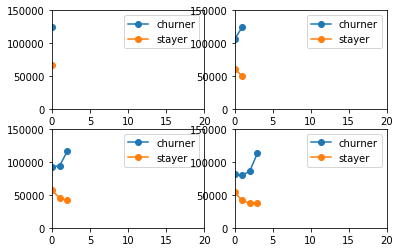

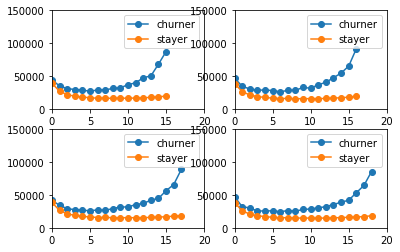

In [47]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[1:], slist[1:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
axlist = [ax1, ax2, ax3, ax4]
for c, s, ax in zip(clist[-4:], slist[-4:], axlist):
    ax.plot(c, '-o', label='churner')
    ax.plot(s, '-o', label='stayer')
    ax.legend()
    ax.axis((0,20,0,15e4))
plt.show()

In [0]:
# Extract temporal features for task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['gap1'] = getTimeGap1OfUser(users, posts)
    features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(features_of_task2[T]['gap1'])
    #features_of_task2[T]['last_gap'] = getTimeLastGapOfPosts(posts).fillna(0)
    features_of_task2[T]['time_since_last_post'] = getTimeSinceLastPost(users, posts, T)
    features_of_task2[T]['mean_gap'] = getTimeMeanGap(posts)
  


3-2. Frequency features

In [0]:
# Frequency features 1: num_answers
# Frequency features 2: num_questions
def getNumAnswers(posts):
    answers = posts[posts['PostTypeId'] == 2]
    return answers.groupby('OwnerUserId')['OwnerUserId'].count()

def getNumQuestions(posts):
    questions = posts[posts['PostTypeId'] == 1]
    return questions.groupby('OwnerUserId')['OwnerUserId'].count()


In [0]:
# Frequency features 3: ans_ques_ratio
def getAnsQuesRatio(num_answers, num_questions):
    # Use Laplace Smoothing
    return (num_answers + 1) / (num_questions + 1)


In [0]:
# Frequency features 4: num_posts
def getNumPosts(posts):
    return posts.groupby('OwnerUserId')['OwnerUserId'].count().astype('float')

In [28]:
# Extract frequency features of task1
for K in list_of_K:
    users, posts = users_of_task1[K], posts_of_task1[K]
    features_of_task1[K]['num_answers'] = getNumAnswers(posts)
    features_of_task1[K]['num_questions'] = getNumQuestions(posts)
    features_of_task1[K] = features_of_task1[K].fillna({'num_answers':0, 'num_questions':0})
    features_of_task1[K]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task1[K]['num_answers'], features_of_task1[K]['num_questions'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [0]:
# Extract frequency features of task2
for T in list_of_T:
    users, posts = users_of_task2[T], posts_of_task2[T]
    features_of_task2[T]['num_answers'] = getNumAnswers(posts)
    features_of_task2[T]['num_questions'] = getNumQuestions(posts)
    features_of_task2[T] = features_of_task2[T].fillna({'num_answers':0,'num_questions':0})
    features_of_task2[T]['ans_que_ratio'] = \
        getAnsQuesRatio(features_of_task2[T]['num_answers'], features_of_task2[T]['num_questions'])
    features_of_task2[T]['num_posts'] = getNumPosts(posts)

# Answers vs Churn probability


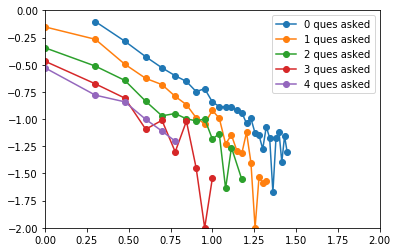

# Answers vs Churn probability


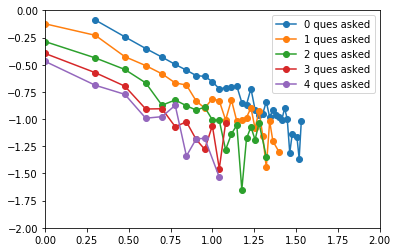

# Answers vs Churn probability


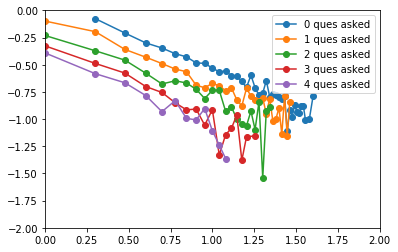

In [30]:
# Figure 3: # Answers vs Churn probability
#    The probability of churning for a user decreases the more answers s/he provides.
#    It is even lower if s/he asks more questions alongside.

min_num_users = 50
for T in list_of_T:
    task2 = features_of_task2[T]
    for num_que_ask in range(5):
        subgroup = task2[task2['num_questions'] == num_que_ask]
        churn_probs = []
        num_answers = list(set(subgroup['num_answers']))
        num_answers.sort()
        for num_ans in num_answers:
            subsubgroup = subgroup[subgroup['num_answers'] == num_ans]
            prob = sum(subsubgroup['is_churn']) / subsubgroup.shape[0]
            if subsubgroup.shape[0] >= min_num_users:
                churn_probs.append((num_ans, prob))

        plt.plot([np.log10(x[0]+1) for x in churn_probs],
                 [np.log10(x[1]+0.01) for x in churn_probs],
                 '-o',
                 label='{} ques asked'.format(num_que_ask))
    print("# Answers vs Churn probability")
    plt.legend()
    plt.axis((0,2,-2,0))
    plt.show()

3-3. Knowledge features

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask1(users, posts, all_posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    all_answers = all_posts[all_posts['PostTypeId'] == 2]
    all_questions = all_posts[all_posts['PostTypeId'] == 1]

    qnta = all_answers.set_index('ParentId')\
        .join(questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    tqna = answers.set_index('ParentId')\
        .join(all_questions, how='inner',\
              lsuffix='A', rsuffix='Q')
    return answers, questions, qnta, tqna

In [0]:
# For the fast extraction, prepare questions x answers
def preprocessForKnowledgeFeaturesForTask2(users, posts):
    answers = posts[posts['PostTypeId'] == 2]
    questions = posts[posts['PostTypeId'] == 1]
    qna = answers\
        .set_index('ParentId').join(questions, how='inner',\
                                    lsuffix='A', rsuffix='Q')
    return answers, questions, qna, qna

In [0]:
# Knowledge features 1: accepted_answerer_rep
def getRepOfAcceptedAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta[qnta['AcceptedAnswerIdQ'] == qnta['IdA']]\
        .set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 2: max_rep_answerer 
def getMaxRepAmongAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]
    rep_max_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].max()
    return rep_max_ans


In [0]:
# Knowledge features 3: num_que_answered
def getNumQueAnswered(users, answers, questions, qnta, tqna):
    # number of questions posted by the user that got answered
    #questions = posts[posts['PostTypeId'] == 1]
    answered_questions = questions[questions['AnswerCount'] > 0]
    return answered_questions.groupby('OwnerUserId')['AnswerCount'].count()


In [0]:
# Knowledge features 4: time_for_first_ans
def getTimeForFirstAns(users, answers, questions, qnta, tqna):
    tmp =  qnta[qnta['CreationDateQ'] < qnta['CreationDateA']]
    tmp['time_for_ans'] = (tmp['CreationDateA'] - tmp['CreationDateQ']).dt.total_seconds() / 60
    questions['time_for_first_ans'] = tmp.groupby(by=tmp.index)['time_for_ans'].min()
    return questions.groupby('OwnerUserId')['time_for_first_ans'].mean()


In [0]:
# Knowledge features 5: rep_questioner
def getAvgRepOfQuestioner(users, answers, questions, qnta, tqna):
    # Avg. reputation of the user whose question was answered
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = tqna.set_index('OwnerUserIdQ')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdA')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 6: rep_answerers
def getAvgRepOfAnswerer(users, answers, questions, qnta, tqna):
    # Avg. reputation of the users who answered the question
    reputations = users.loc[:, ['Reputation']]
    rep_accepted_ans = qnta.set_index('OwnerUserIdA')\
        .join(reputations, how='inner')\
        .groupby('OwnerUserIdQ')['Reputation'].mean()
    return rep_accepted_ans


In [0]:
# Knowledge features 7: rep_co_answerers
def getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna):
    reputations = users.loc[:, ['Reputation']]    
    rep_ans = answers.set_index('OwnerUserId')\
        .join(reputations, how='inner')\
        .set_index('ParentId')\
        .join(questions, how='inner', lsuffix='A', rsuffix='Q')
    avg_rep_ans = rep_ans.groupby(by=rep_ans.index)['Reputation'].mean()
    rep_co_answerer = answers.set_index('ParentId')\
        .join(avg_rep_ans, how='inner')\
        .set_index('OwnerUserId')
    return rep_co_answerer.groupby(by=rep_co_answerer.index)['Reputation'].mean()


In [0]:
# Knowledge features 8: num_answers_recvd
def getAvgNumAnsReceived(users, answers, questions, qnta, tqna):
    #questions = posts[posts['PostTypeId'] == 1]
    return questions.fillna({'AnswerCount': 0}).groupby('OwnerUserId')['AnswerCount'].mean()


In [41]:
# Extract knowledge features of task 1
for K in list_of_K:
    print("Extract knowledge features of task1(K=",K,")")
    users, posts = users_of_task1[K], posts_of_task1[K]
    answers, questions, qnta, tqna = preprocessForKnowledgeFeaturesForTask1(users, posts, posts_df)
    features_of_task1[K]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['num_que_answered'] = getNumQueAnswered(users, answers, questions,  qnta, tqna)
    features_of_task1[K]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qnta, tqna)
    features_of_task1[K]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qnta, tqna)

Extract knowledge features of task1(K= 1 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task1(K= 2 )
Extract knowledge features of task1(K= 3 )
Extract knowledge features of task1(K= 4 )
Extract knowledge features of task1(K= 5 )
Extract knowledge features of task1(K= 6 )
Extract knowledge features of task1(K= 7 )
Extract knowledge features of task1(K= 8 )
Extract knowledge features of task1(K= 9 )
Extract knowledge features of task1(K= 10 )
Extract knowledge features of task1(K= 11 )
Extract knowledge features of task1(K= 12 )
Extract knowledge features of task1(K= 13 )
Extract knowledge features of task1(K= 14 )
Extract knowledge features of task1(K= 15 )
Extract knowledge features of task1(K= 16 )
Extract knowledge features of task1(K= 17 )
Extract knowledge features of task1(K= 18 )
Extract knowledge features of task1(K= 19 )
Extract knowledge features of task1(K= 20 )


In [42]:
for T in list_of_T:
    print("Extract knowledge features of task2(T=)",T,")")
    users, posts = users_of_task2[T], posts_of_task2[T]
    answers, questions, qna, qna1 = preprocessForKnowledgeFeaturesForTask2(users, posts)
    features_of_task2[T]['accepted_answerer_rep'] = getRepOfAcceptedAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['max_rep_answerer'] = getMaxRepAmongAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_que_answered'] = getNumQueAnswered(users, answers, questions, qna, qna1)
    features_of_task2[T]['time_for_first_ans'] = getTimeForFirstAns(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_questioner'] = getAvgRepOfQuestioner(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_answerers'] = getAvgRepOfAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['rep_co_answerers'] = getAvgRepOfCoAnswerer(users, answers, questions, qna, qna1)
    features_of_task2[T]['num_answers_recvd'] = getAvgNumAnsReceived(users, answers, questions, qna, qna1)

Extract knowledge features of task2(T=) 7 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Extract knowledge features of task2(T=) 15 )
Extract knowledge features of task2(T=) 30 )


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


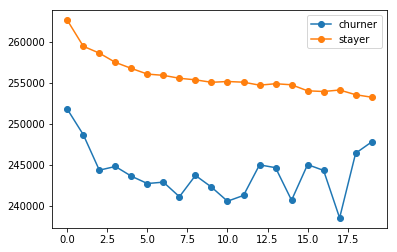

In [43]:
# Figure 4: K vs Time taken for the first answer to arrive
#  The more the time taken for a user to receive an answer, 
#  the lesser the satisfaction level and the more the chances of churning.
churners_time = []
stayers_time = []
for K in list_of_K:
    subgroup = features_of_task1[K]
    churners = subgroup[subgroup['is_churn'] == 1][subgroup['time_for_first_ans'] > 0] 
    stayers = subgroup[subgroup['is_churn'] == 0][subgroup['time_for_first_ans'] > 0]
    churners_time.append(churners['time_for_first_ans'].mean())
    stayers_time.append(stayers['time_for_first_ans'].mean())
    

plt.plot(churners_time, '-o', label='churner')
plt.plot(stayers_time, '-o', label='stayer')
plt.legend()
# plt.axis((0,20,8e3,22e3))
plt.show()

Implement the other features yourself!!

3-4. Speed features

3-5. Quality features

3-6. Consistency features

3-7. Gratitude features

3-8. Competitiveness features

3-9. Content features

In [44]:
# Store the whole features of task1 to Google Drive
for K in list_of_K:
    store_df_at_google_drive('task1_{}posts_features.csv'.format(K), features_of_task1[K])
    #features_of_task1[K].to_pickle('task1_{}posts_important_features.pkl'.format(K))
    #features_of_task1[K].to_csv('task1_{}posts_important_features.csv'.format(K))

Uploaded file with ID 1-Qvbs8UAsbpZ9cHlZS_KLgIXRDriTnAF
Uploaded file with ID 1d4ArQ_EYUl5SH04G15QyMTUHq0V_v8ug
Uploaded file with ID 1RMgCDSQazOOamZ3p4jaC2fKBWwjjcoTK
Uploaded file with ID 14WKdCO2IpUv-SD1j1dtdcR5prUC2zkCT
Uploaded file with ID 1x-exoMqiOUp7kp9SvWUyJiajlbUBRt2d
Uploaded file with ID 1N4l0dwZwrTZUiRrIzO1y_t5xPXEIrgwJ
Uploaded file with ID 1oPr6-tzCR6UT9nzsqCYKBqiy0URl96K2
Uploaded file with ID 1Su7zStos6nEHf0xck5sOdWFC4msNGmYQ
Uploaded file with ID 1_-E0CFFXIZsF8j0RY7Ng0dAymcgKvo55
Uploaded file with ID 124u0akZXq5Qs2q3xCkWQztxsKwXjb5NU
Uploaded file with ID 1XMP4cBlEXv05wsjlb5FTUvzuo-vxPAH3
Uploaded file with ID 1gjvVXWX9EWhMxFVo0EF1h5kjpbuFGsYR
Uploaded file with ID 1XExwmvxCdiPFwFdir3pT6YjIigRQQ9hB
Uploaded file with ID 1npLu7HJVCBaCAEMTB5A5XY2F1gq_iqxM
Uploaded file with ID 1Yu1biikRG679IuBh2XYRgvoz_Jky3_UK
Uploaded file with ID 1ZtDRCBTFbYaw__NICT3WJowlRn2nCJea
Uploaded file with ID 1JtO0RAVtH1XBFW8timf8cONHNFe7D7NP
Uploaded file with ID 1BodqUYJ_dmbquMABEjpiWbkhc

In [45]:
for T in list_of_T:
    store_df_at_google_drive('task2_{}posts_features.csv'.format(T), features_of_task2[T])
    #features_of_task2[T].to_pickle('task2_{}days_important_features.pkl'.format(T))
    #features_of_task2[T].to_csv('task2_{}days_important_features.csv'.format(T))

Uploaded file with ID 12Z4laJYlB69qZifvcslKNZlkdHtWL9_N
Uploaded file with ID 188CYFTGltMYEHqe3zpSvlEgqpxD1I72w
Uploaded file with ID 1E8f07g0-oI-WaYFxuCWCHbHvDsAP4XOh


5. Train models for each tasks with the features

    1. Decision Tree
    2. SVM (Linear)
    3. SVM (RBF)
    4. Logistic Regression

In [0]:
def fill_nan(features):
    if 'time_for_first_ans' in features.columns and np.isnan(features['time_for_first_ans']).sum(0):
        features['time_for_first_ans'] = 1 / features['time_for_first_ans']
        features['time_for_first_ans'] = features['time_for_first_ans'].replace([np.nan], 0)
    fill_constants = {
        'accepted_answerer_rep': 0,
        'max_rep_answerer': 0,
        'num_que_answered': 0, 
        'rep_questioner': 0,
        'rep_answerers': 0,
        'rep_co_answerers': 0,
        'num_answers_recvd': 0
    }
    return features.fillna(fill_constants)
                                                                         

In [47]:
for K in list_of_K:
    print("Fill NaN of task1(K=",K,")")
    features_of_task1[K] = fill_nan(features_of_task1[K])


Fill NaN of task1(K= 1 )
Fill NaN of task1(K= 2 )
Fill NaN of task1(K= 3 )
Fill NaN of task1(K= 4 )
Fill NaN of task1(K= 5 )
Fill NaN of task1(K= 6 )
Fill NaN of task1(K= 7 )
Fill NaN of task1(K= 8 )
Fill NaN of task1(K= 9 )
Fill NaN of task1(K= 10 )
Fill NaN of task1(K= 11 )
Fill NaN of task1(K= 12 )
Fill NaN of task1(K= 13 )
Fill NaN of task1(K= 14 )
Fill NaN of task1(K= 15 )
Fill NaN of task1(K= 16 )
Fill NaN of task1(K= 17 )
Fill NaN of task1(K= 18 )
Fill NaN of task1(K= 19 )
Fill NaN of task1(K= 20 )


In [48]:
for T in list_of_T:
    print("Fill NaN of task2(T=)",T,")")
    features_of_task2[T] = fill_nan(features_of_task2[T])


Fill NaN of task2(T=) 7 )
Fill NaN of task2(T=) 15 )
Fill NaN of task2(T=) 30 )


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

seed = 1234
np.random.seed(seed)

def LogisticRegression_(*arg, **kwarg):
    kwarg['max_iter'] = 1e3
    kwarg['solver'] = 'saga'
    kwarg['n_jobs'] = 8
    return LogisticRegression(*arg, **kwarg)

  

In [0]:
def learn_model(data, train_features, target='is_churn', model=DecisionTreeClassifier, seed=seed):
    X = data[train_features]
    y = data[target]
    print(model.__name__)
        
    ### 10-fold cross validation ###
    acc_list = []
    kf = KFold(n_splits=10, shuffle=True, random_state=seed)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        ### Under-sampling ###
        churners = y_train[y_train == 1].index
        stayers = y_train[y_train == 0].index
        n_churn = len(churners)
        n_stay = len(stayers)
        if n_churn > n_stay:
            churners = np.random.choice(churners, n_stay, replace=False)
        else:
            stayers = np.random.choice(stayers, n_churn, replace=False)
        train_index = np.array(list(churners) + list(stayers))
        X_train, y_train = X.reindex(train_index), y.reindex(train_index)

        ### Learn Model ###
        mdl = model().fit(X_train, y_train)
        pred = mdl.predict(X_test)
        acc = (pred == y_test)
        acc_list.append(sum(acc)*100/len(acc))
    return acc_list

In [51]:
# Table 2: Performance on Task 1

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate', 'num_posts']

# model = LogisticRegression_
model = DecisionTreeClassifier

for K in list_of_K:
    print('Task 1, K={}'.format(K))
    train_features = [col for col in features_of_task1[K].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task1[K], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 1, K=1
DecisionTreeClassifier
Accuracy: 58.442373686893006
    for each folds: [58.765866313791726, 58.69447878397437, 58.48379851304999, 58.202744114779215, 58.28458002507313, 58.34029809165622, 58.4360635185959, 58.10001392951665, 58.64848864744393, 58.46740493104889]
Task 1, K=2
DecisionTreeClassifier
Accuracy: 54.02045753835788
    for each folds: [53.74697577557958, 53.79903837319695, 54.22166416562031, 54.15122653354975, 53.93378862585367, 54.289039291948676, 54.411539521636605, 53.91847609714268, 53.866413499525315, 53.866413499525315]
Task 1, K=3
DecisionTreeClassifier
Accuracy: 55.551213284398294
    for each folds: [55.23572613124852, 55.53800592300099, 56.02369200394867, 55.332675222112535, 55.96051332675222, 55.735439289239885, 55.78677196446199, 55.34452122408687, 55.11154985192498, 55.44323790720632]
Task 1, K=4
DecisionTreeClassifier
Accuracy: 56.626406267954906
    for each folds: [57.74615025664956, 56.11759216052263, 57.158189454036396, 56.37890807279515, 56.2648

In [52]:
# Table 3: Performance on Task 2

drop_user_columns = ['Reputation', 'CreationDate', 'LastAccessDate']

# model = LogisticRegression_
model = DecisionTreeClassifier

for T in list_of_T:
    print('Task 2, T={}'.format(T))
    train_features = [col for col in features_of_task2[T].columns 
                      if col not in drop_user_columns + ['is_churn']]

    acc_list = learn_model(features_of_task2[T], train_features, model=model)
    print('Accuracy: {}'.format(np.mean(acc_list)))
    print('    for each folds: {}'.format(acc_list))


Task 2, T=7
DecisionTreeClassifier
Accuracy: 66.14042318269138
    for each folds: [66.53058431783971, 66.61953199835789, 66.32075902020709, 66.21128495187702, 65.77338867855677, 66.0120880374045, 66.03717641692326, 66.03489565514882, 65.740677386247, 66.1238453643517]
Task 2, T=15
DecisionTreeClassifier
Accuracy: 67.36253295846942
    for each folds: [67.13232867671323, 67.13672863271367, 67.4132089585075, 67.46160953931447, 67.40660887930655, 67.30100761209134, 67.46160953931447, 67.40440885290623, 67.07000484005808, 67.83781405376864]
Task 2, T=30
DecisionTreeClassifier
Accuracy: 68.22386916507344
    for each folds: [68.16968258676951, 68.20782302835106, 68.21417976861466, 68.31588761283214, 68.31164978598974, 68.20570411492986, 68.1414616574492, 68.38090394761934, 67.95711228360138, 68.33428686457738]


In [0]:
# Figure 5: Churn prediction accuracy when features from each category are used in isolation

temporal_features = ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
frequency_features = ['num_answers', 'num_questions',
                      'ans_que_ratio', 'num_posts']
speed_features = ['answering_speed']
quality_features = ['ans_score', 'que_score']
consistency_features = ['ans_stddev', 'que_stddev']
gratitude_features = ['ans_comments', 'que_comments']
competitiveness_features = ['relative_rank_pos']
content_features = ['ans_length', 'que_length']
knowledge_features = ['accepted_answerer_rep', 'max_rep_answerer',
                      'num_que_answered', 'time_for_first_ans',
                      'rep_questioner', 'rep_answerers',
                      'rep_co_answerers', 'num_answers_recvd']

analysis_feature_names = {
    'temporal': temporal_features,
    'frequency': frequency_features,
    'speed': speed_features,
    'quality': quality_features,
    'consistency': consistency_features,
    'gratitude': gratitude_features,
    'competitiveness': competitiveness_features,
    'content': content_features,
    'knowledge': knowledge_features,
}

In [54]:
task1_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for K in list_of_K:
        if name == 'temoral':
            feature_list = ['gap{}'.format(j) for j in range(1, K+1)]
        elif name == 'frequency':
            features_list = [feat for feat in feature_list if feat != 'num_posts']
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_of_category[name] = accuracy_of_category


temporal, Task 1, K=1
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 58.77563696942855
    for each folds: [59.00266397367367, 58.682290669127504, 58.49076315010534, 58.73380693689929, 58.810419278451036, 58.70072433486558, 59.04547987184845, 58.46218136230673, 59.13776291962669, 58.69027719738125]

temporal, Task 1, K=2
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 49.932624873671635
    for each folds: [49.65853060974489, 49.89434355189416, 49.98621872416011, 50.23734419502036, 50.10259394236364, 50.0107187700977, 49.77796833369062, 49.796343368143816, 50.01990628732429, 49.84228095427679]

temporal, Task 1, K=3
    columns: ['gap1']
DecisionTreeClassifier
Accuracy: 49.150054035748965
    for each folds: [48.8154465766406, 49.17670286278381, 49.30700888450148, 48.50148075024679, 48.89634748272458, 49.55577492596249, 49.55577492596249, 49.45705824284304, 48.87265547877591, 49.36229022704837]

temporal, Task 1, K=4
    columns: ['gap1']
DecisionTreeClassifier
Accuracy

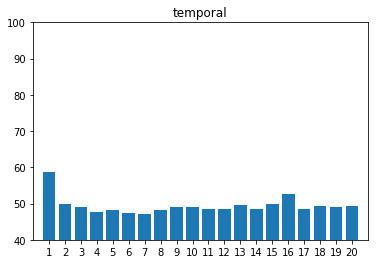

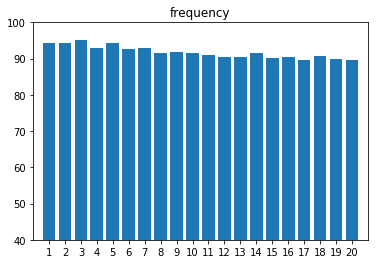

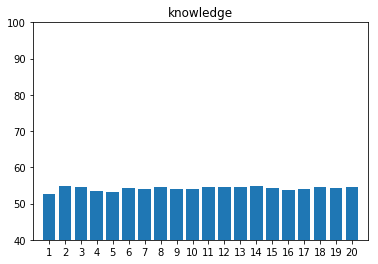

In [55]:
# Bar Chart
for title, predictions in task1_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_K)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_K, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(40, 100)
    plt.show()


In [56]:
### Category Analysis - Task 2 ###
task2_accuracy_of_category = {}
for name, feature_list in analysis_feature_names.items():
    accuracy_of_category = []
    for T in list_of_T:
        train_features = [feat for feat in feature_list if feat in features_of_task2[T].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 2, T={}'.format(name, T))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task2[T], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_of_category.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task2_accuracy_of_category[name] = accuracy_of_category


temporal, Task 2, T=7
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 66.28205820798885
    for each folds: [66.22040779090453, 66.56479496419286, 66.30707476166583, 66.32303972996397, 66.16339004698263, 65.95734975481811, 66.55262857794503, 66.30858706808074, 66.01664956095335, 66.40665982438135]

temporal, Task 2, T=15
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 67.35131203490621
    for each folds: [67.45132548674513, 67.17632823671764, 67.27680732168785, 67.27460729528754, 67.45720948651383, 67.46380956571478, 67.25260703128437, 67.257007084085, 67.45060940731288, 67.4528094337132]

temporal, Task 2, T=30
    columns: ['gap1', 'last_gap', 'time_since_last_post', 'mean_gap']
DecisionTreeClassifier
Accuracy: 68.34613130459593
    for each folds: [68.3455524007289, 68.44937915836759, 68.42819002415561, 67.95567233122854, 68.47268720600076, 68.60194092469382, 68.2940266564

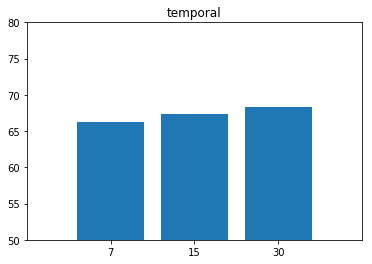

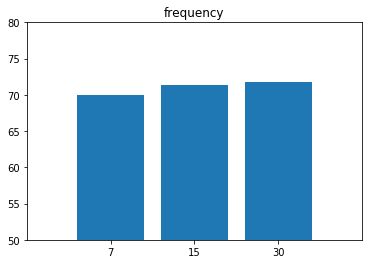

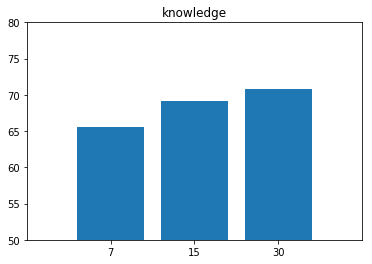

In [57]:
# Bar Chart
for title, predictions in task2_accuracy_of_category.items():
    if len(predictions) == 0:
        continue
    n_groups = len(list_of_T)
    index = np.arange(n_groups)

    plt.bar(index, predictions, tick_label=list_of_T, align='center')

    plt.title(title)
    plt.xlim(-1, n_groups)
    plt.ylim(50, 80)
    plt.show()


In [58]:
### Temporal Feature Analysis - Task 1 ###
temporal_analysis_feature_func = {
    'gapK': lambda K: ['gap{}'.format(j) for j in range(1, K+1)],
    'last_gap': lambda K: ['gap{}'.format(K)]
}


task1_accuracy_with_time_gap = {}
for K in list_of_K:
    accuracy_with_time_gap = []
    for name, feature_func in temporal_analysis_feature_func.items():
        train_features = [feat for feat in feature_list if feat in features_of_task1[K].columns]
        if len(train_features) == 0:
            continue
        print('\n{}, Task 1, K={}'.format(name, K))
        print('    columns: {}'.format(train_features))

        acc_list = learn_model(features_of_task1[K], train_features)
        mean_acc = np.mean(acc_list)
        accuracy_with_time_gap.append(mean_acc)
        print('Accuracy: {}'.format(mean_acc))
        print('    for each folds: {}'.format(acc_list))

    task1_accuracy_with_time_gap[K] = accuracy_with_time_gap


gapK, Task 1, K=1
    columns: ['accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered', 'time_for_first_ans', 'rep_questioner', 'rep_answerers', 'rep_co_answerers', 'num_answers_recvd']
DecisionTreeClassifier
Accuracy: 52.62509059078965
    for each folds: [52.61957411244406, 52.699667438580605, 52.65265613845698, 52.61178437108232, 52.599596044017275, 52.61526675024377, 52.43940660259089, 52.773715002089425, 52.45507730881739, 52.78416213957376]

last_gap, Task 1, K=1
    columns: ['accepted_answerer_rep', 'max_rep_answerer', 'num_que_answered', 'time_for_first_ans', 'rep_questioner', 'rep_answerers', 'rep_co_answerers', 'num_answers_recvd']
DecisionTreeClassifier
Accuracy: 52.59705776293068
    for each folds: [52.441975867532605, 52.61609179391639, 52.727525986802014, 52.62919626688954, 52.42547708594512, 52.5856665273715, 52.45855968797883, 52.71973812508706, 52.56477225240284, 52.80157403538097]

gapK, Task 1, K=2
    columns: ['accepted_answerer_rep', 'max_rep_answerer'

In [59]:
# Table 4: Temporal gap features analysis

for K, acc in task1_accuracy_with_time_gap.items():
    print(K, acc)

1 [52.62509059078965, 52.59705776293068]
2 [55.31559121673352, 54.879490399044506]
3 [54.443613393880824, 54.54509824465475]
4 [53.36080372808472, 53.56846680767427]
5 [53.45852401895833, 53.27011242348652]
6 [54.48552632574952, 54.54373644270392]
7 [54.00296336981047, 54.24956475684129]
8 [54.12299389291294, 54.10808123846044]
9 [53.6531675281705, 54.02197534647731]
10 [53.90160844581859, 54.11450358004854]
11 [54.412032960704416, 54.52936628647158]
12 [54.70928919056812, 54.932442942100536]
13 [53.98538695291827, 54.23611165490951]
14 [54.83059669376534, 54.47748399637489]
15 [54.28544073228704, 54.63589394163574]
16 [54.46474287554506, 53.83118749139716]
17 [54.60532877080184, 54.698220223504805]
18 [54.124557653036426, 54.56682345698347]
19 [54.40502085775303, 54.289909627841055]
20 [53.9277564542965, 54.04068877348622]
